In [1]:


import numpy as np
import porepy as pp
import scipy.sparse as sps
import math 
import sys
sys.path.append("../class")
from Flow_class import Flow
from Transport_class import Transport
from Reaction_class import Reaction

In [2]:
Nx=100
Ny=5

In [3]:
#gb= pp.grid_buckets_2d.single_vertical([Nx, Ny], y_endpoints=[0.6, 0.2], simplex=False)
#gb, domain = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)
#print(domain)
#pp.plot_grid(gb,figsize=[15,12])
#domain={'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}




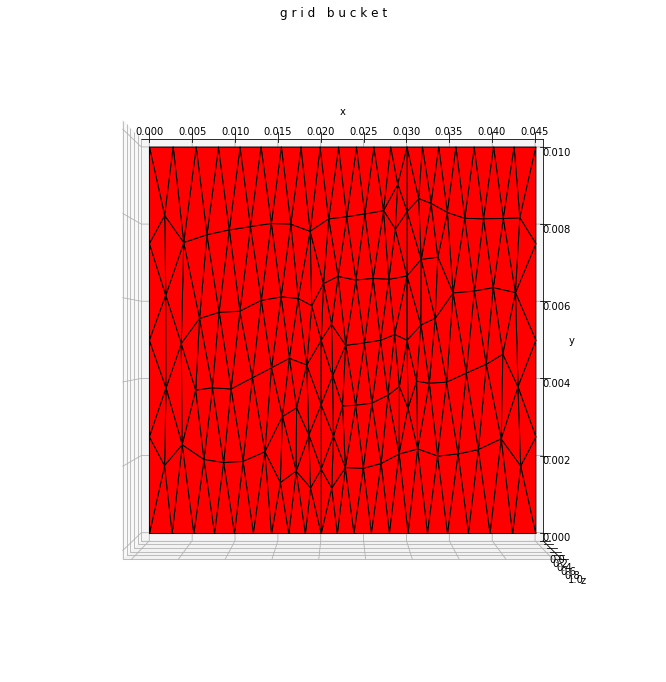

In [4]:
# Point coordinates, as a 2xn array
p = np.array([[0.02,0.02,0.03,0.03], [0,0.005,0.005,0.01]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': 0, 'xmax': 0.045, 'ymin': 0, 'ymax': 0.01}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
#mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}
mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}


# Generate a mixed-dimensional mesh
gb = network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

In [6]:
parameter={"aperture":1e-3,
           "fracture_perm":0.00001,
          #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
          #"fracture_perm":0.001,
           "perm":0.3,
           #"perm":1,
          
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          "bc_value":[3.0e-7,0.0],
           #"bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

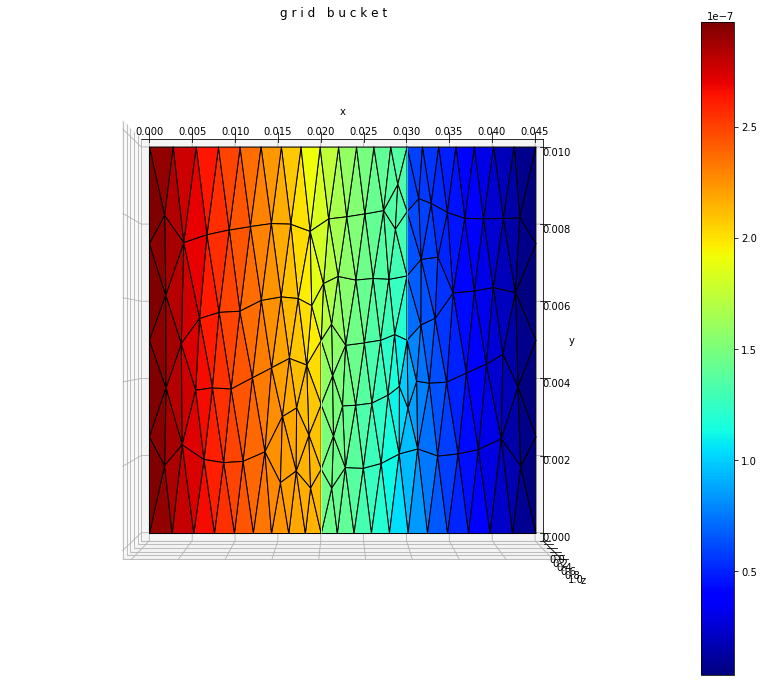

In [7]:
flow=Flow(gb,domain,parameter)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [8]:
parameter={
    "aperture":1e-3,
    "por":0.3,
    "por_frac":0.00001,
    #"por":1.0,
    #"por_frac":1.0,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"time_step":0.001,
    #"t_max":1 /3,
    "t_max":345600,
    #"t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport=Transport(gb,domain,parameter)

In [9]:
Ca_value=[0.0,0.0]
Ca_type=['dir','dir']
CaSiO3_value=[0.0,0.0]
CaSiO3_type=['dir','dir']
Ca="Ca"
CaSiO3="CaSiO3"

In [10]:
reaction_data={"temperature":423,
       "A":1.9e-2,
       "rate_const":0.004466,
       #"rate_const":0.0,
       "E":4700,
       "R":8.314,
       "K_eq":10e9,
       "ph":3.5,
       "mass_weight":0.3*1}
reaction=Reaction(reaction_data)
reaction.set_const_rate()
print(reaction.const_rate)

2.229802863847148e-05


In [11]:
transport.set_data(Ca_value,Ca_type,Ca)
transport.get_flux(Ca)
transport.discretize(Ca)
lhs_Ca,rhs_source_adv_Ca,rhs_mass_Ca,assembler_Ca=transport.get_transport_lhs_rhs(Ca)
#ciao?1



In [12]:
for g,d in gb:
    print(d[pp.PARAMETERS]["Ca"]["darcy_flux"])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.79842944e-10
  4.98575039e-10  0.00000000e+00  3.19507934e-09 -2.58379516e-09
 -6.77253034e-09  5.51216912e-09  4.62718430e-09  0.00000000e+00
 -6.92451767e-09 -3.23402481e-09  3.65788058e-09  5.58483755e-09
 -5.90072120e-09  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.89380741e-10  4.37876989e-10  0.00000000e+00 -3.95198165e-09
 -2.68538399e-09  0.00000000e+00  4.07900631e-09  2.78313767e-09
  3.90458209e-09  0.00000000e+00  2.66955290e-09  0.00000000e+00
 -4.10463662e-09 -2.82033360e-09  0.00000000e+00  1.35456355e-09
 -4.98575039e-10  0.00000000e+00  1.47997642e-09 -1.35456355e-09
  0.00000000e+00 -1.47997642e-09  2.76481246e-09  0.00000000e+00
 -2.81306736e-09  2.76481246e-09  0.00000000e+00 -2.81306736e-09
 -2.86204213e-09  0.00000000e+00  2.97524343e-09  2.86204213e-09
  0.00000000e+00 -2.97524343e-09  3.53768755e-09 -3.53768755e-09
  2.68538399e-09  0.00000000e+00 -1.72839386e-09  5.79842944e-10
  0.00000000e+00  2.60325

In [13]:
print(rhs_source_adv_Ca)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


P0_flux
[[ 1.43156536e-06  1.48574640e-06  1.33237611e-06  1.19406580e-06
   1.47909679e-06  1.47150435e-06  1.12652108e-06  2.07296776e-06
   1.38994610e-06  1.67770181e-06  2.51572388e-06  1.81873413e-06
   2.01501174e-06  4.78644640e-10  1.65933096e-06  1.62555819e-06
   4.52611729e-10  4.80232010e-10  5.98681691e-07  2.10342143e-06
   8.49485993e-07  1.99324003e-06  1.59517239e-06  2.27159646e-06
   1.73225446e-06  6.80739589e-10  1.60560246e-06  2.58088943e-06
   1.58705641e-06  2.19120709e-06  1.25037865e-06  1.55350992e-06
   1.74570332e-06  2.45005431e-06  1.01459702e-06  9.65459025e-07
   9.13754619e-07  1.35312386e-06  2.04027631e-06  9.06961170e-07
   1.54707887e-06  1.74584751e-06  1.58844816e-06  1.67614405e-06
   1.53669944e-06  1.13180403e-06  1.87206178e-06  1.55801723e-06
   1.59525285e-06  2.28433945e-06  1.24062768e-06  1.98152887e-06
   1.49236005e-06  2.58981061e-06  1.58691810e-06  2.08284201e-06
   2.26689992e-06  2.62213976e-06  1.48711403e-06  2.23901928e-06
  

/home/dell/anaconda3/lib/python3.8/site-packages/porepy/viz/plot_grid.py:127: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


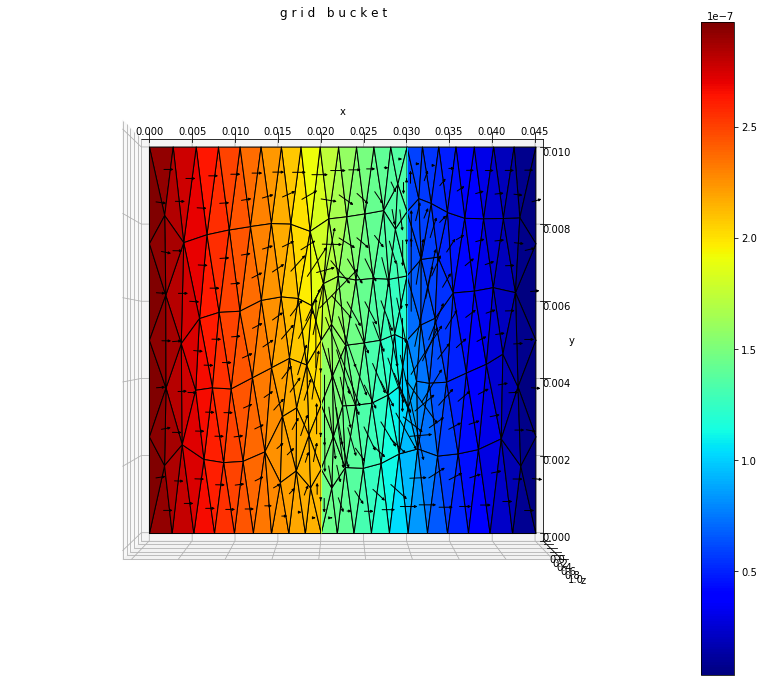

In [14]:
## to export the flux
key='Ca'
flux='darcy_flux'
mortar='mortar_flux'
flux_P0="P0_flux"

discr_P0_flux = pp.MVEM(key)
for g, d in gb:
    discr_P0_flux.discretize(g, d)
    d[pp.STATE][flux] = d[pp.PARAMETERS][key][flux]

## construct the P0 flux reconstruction
pp.project_flux(gb, discr_P0_flux, flux, flux_P0, mortar)

for g,d in gb:
    print("P0_flux")
    print(d[pp.STATE]["P0_flux"])

for g,d in gb:
    print("pressure")
    print(d[pp.STATE]["pressure"])
    
for g,d in gb:
    d[pp.STATE]["P0_flux"]*=1000
pp.plot_grid(gb,"pressure","P0_flux",figsize=(15,12))

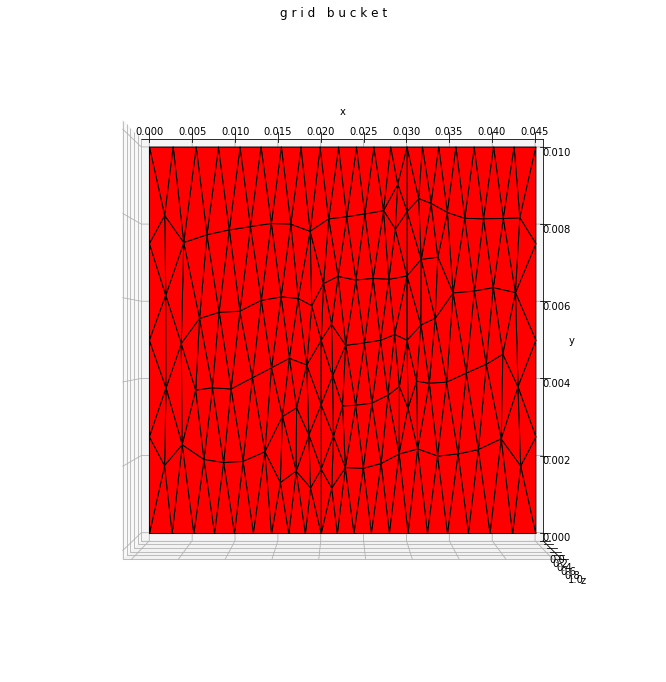

In [15]:
# Point coordinates, as a 2xn array
p = np.array([[0.02,0.02,0.03,0.03], [0,0.005,0.005,0.01]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': 0, 'xmax': 0.045, 'ymin': 0, 'ymax': 0.01}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
#mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}
mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}


# Generate a mixed-dimensional mesh
gb1= network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

In [16]:
parameter={"aperture":1e-3,
           "fracture_perm":0.00001,
          #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
           #"fracture_perm":1.0,
           "perm":0.3,
           #"perm":1.0,
           #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          #"bc_value":[3.0e-7,0.0],
          "bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

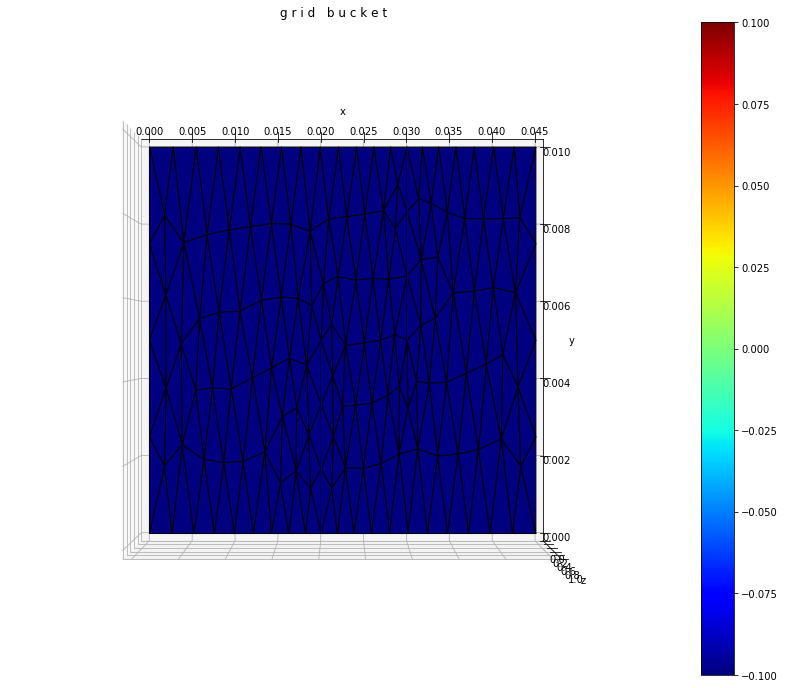

In [17]:
flow=Flow(gb1,domain,parameter)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [18]:
parameter={
    "aperture":1e-3,
    "por":0.3,
    "por_frac":0.00001,
    #"por":1.0,
    #"por_frac":1.0,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"time_step":0.001,
    #"t_max":1 /3,
    "t_max":345600,
    #"t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport_CaSiO3=Transport(gb1,domain,parameter)

In [19]:
transport_CaSiO3.set_data(CaSiO3_value,CaSiO3_type,CaSiO3)
transport_CaSiO3.get_flux(CaSiO3)    
transport_CaSiO3.discretize(CaSiO3)
lhs_CaSiO3,rhs_source_adv_CaSiO3,rhs_mass_CaSiO3,assembler_CaSiO3=transport_CaSiO3.get_transport_lhs_rhs(CaSiO3)

In [20]:
save_every = 100
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer1 = np.zeros(rhs_source_adv_Ca.size)
assembler_Ca.distribute_variable(
    tracer1, variable_names=[Ca,transport.mortar_variable]
)

tracer2 = 16.7504*np.ones(rhs_source_adv_CaSiO3.size)
assembler_CaSiO3.distribute_variable(
    tracer2, variable_names=[CaSiO3,transport.mortar_variable]
)


# Exporter
exporter1 = pp.Exporter(gb, file_name="Ca", folder_name="Ca")
export_field1 = ["Ca"]
IEsolver_Ca = sps.linalg.factorized(lhs_Ca)

exporter2= pp.Exporter(gb1, file_name="CaSiO3", folder_name="CaSiO3")
export_field2 = ["CaSiO3"]
IEsolver_CaSiO3 = sps.linalg.factorized(lhs_CaSiO3)

/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [21]:

rd=np.zeros(tracer1.size)
#for i in range(10):
#for i in range(n_steps):
for i in range(1,n_steps+1,1):
    rd=reaction.compute_rd(tracer1,rd)
    if np.isclose((i-1) % save_every, 0):
            exporter1.write_vtu(export_field1, time_step=int((i-1) // save_every))
            exporter2.write_vtu(export_field2, time_step=int((i-1) // save_every))
            for g,d in gb:
                print("Ca")
                print(d[pp.STATE]["Ca"])
            for g,d in gb1:
                print("CaSiO3")
                print(d[pp.STATE]["CaSiO3"])
            print("FINE")
            print("rd")
            print(rd)
    
    #rd=reaction.compute_rd(tracer1,rd)
    tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca+rhs_mass_Ca*rd*tracer2*parameter["time_step"])
    tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3-rhs_mass_CaSiO3*rd*tracer2*parameter["time_step"])
    #tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca)
    #tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3)
    
    
    assembler_Ca.distribute_variable(
        tracer1,
        variable_names=[Ca,transport.mortar_variable],
    )
    assembler_CaSiO3.distribute_variable(
        tracer2,
        variable_names=[CaSiO3,transport.mortar_variable],
    )
    #print("tracer1")
    #print(tracer1)
    
exporter1.write_vtu(export_field1, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
    
exporter2.write_vtu(export_field2, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
exporter1.write_pvd(time_steps)
exporter2.write_pvd(time_steps)
transport.plot_tracer(Ca)
transport_CaSiO3.plot_tracer(CaSiO3)

ciao?1

SyntaxError: invalid syntax (2099301348.py, line 51)